## Agrupación de IPs por sus palabras clave

Paso 1: Cargar el dataset

In [1]:
import pandas as pd

df = pd.read_csv("Keywords/author_keyword_matrix.csv", index_col=0)

# Mostrar resumen
print("✅ Dataset generado con forma:", df.shape)
print("🔢 Palabras clave totales:", len(df.columns))
print("👥 Autores con keywords:", len(df))

✅ Dataset generado con forma: (29, 3329)
🔢 Palabras clave totales: 3329
👥 Autores con keywords: 29


Paso 2: Preprocesamiento (normalización y reducción PCA)

In [2]:
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

X = df.values
X_normalized = Normalizer().fit_transform(X)

Paso 3: Clustering con Jerárquico

In [3]:
# === Configuraciones de preprocesamiento y clustering ===
pca_dims = [2, 5, 10, 20]
k_values = list(range(2, 16))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Evaluar KMeans para k entre 2 y 15
results = []

for n_dim in pca_dims:
    X_reduced = PCA(n_components=n_dim).fit_transform(X_normalized)

    Z = linkage(X_reduced, method='ward')

    for k in k_values:
        try:
            labels = fcluster(Z, t=k, criterion='maxclust')

            silhouette = silhouette_score(X_reduced, labels)
            ch_score = calinski_harabasz_score(X_reduced, labels)
            db_score = davies_bouldin_score(X_reduced, labels)

            results.append({
                "PCA_dims": n_dim,
                "k": k,
                "Silhouette": silhouette,
                "Calinski-Harabasz": ch_score,
                "Davies-Bouldin": db_score,
                "Labels": labels
            })

        except Exception as e:
            results.append({
                "PCA_dims": n_dim,
                "k": k,
                "Silhouette": np.nan,
                "Calinski-Harabasz": np.nan,
                "Davies-Bouldin": np.nan,
                "Error": str(e),
                "Labels": []
            })

df_results = pd.DataFrame(results).dropna(subset=["Silhouette"])
print("✅ Resultados de clustering jerárquico generados:", df_results.shape)
print("🔍 Resultados de clustering:", df_results)

✅ Resultados de clustering jerárquico generados: (56, 6)
🔍 Resultados de clustering:     PCA_dims   k  Silhouette  Calinski-Harabasz  Davies-Bouldin  \
0          2   2    0.472844          25.670981        0.821027   
1          2   3    0.578545          47.611685        0.587036   
2          2   4    0.538778          44.789039        0.539631   
3          2   5    0.572269          50.811216        0.493005   
4          2   6    0.600156          61.873382        0.483606   
5          2   7    0.660430          70.878673        0.392103   
6          2   8    0.630787          93.109994        0.458675   
7          2   9    0.626714         108.962550        0.495996   
8          2  10    0.622107         121.913329        0.515559   
9          2  11    0.666728         139.471644        0.455157   
10         2  12    0.641305         152.838998        0.374732   
11         2  13    0.626362         180.284061        0.286989   
12         2  14    0.597662         211.071

In [5]:
## Selección por score combinado
from sklearn.preprocessing import MinMaxScaler

metrics = df_results[["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]].copy()
metrics["Davies-Bouldin"] = -metrics["Davies-Bouldin"]
scaled = pd.DataFrame(MinMaxScaler().fit_transform(metrics), columns=metrics.columns)

df_results["score_combined"] = (
    0.8 * scaled["Silhouette"] +
    0.1 * scaled["Calinski-Harabasz"] +
    0.1 * scaled["Davies-Bouldin"]
)

best_per_k = (
    df_results
    .sort_values("score_combined", ascending=False)
    .drop_duplicates(subset=["k"])
    .sort_values("k")
)

print("✅ Mejores configuraciones jerárquicas por número de clusters:")
print(best_per_k[["PCA_dims", "k", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin", "score_combined"]])

✅ Mejores configuraciones jerárquicas por número de clusters:
    PCA_dims   k  Silhouette  Calinski-Harabasz  Davies-Bouldin  \
0          2   2    0.472844          25.670981        0.821027   
1          2   3    0.578545          47.611685        0.587036   
2          2   4    0.538778          44.789039        0.539631   
3          2   5    0.572269          50.811216        0.493005   
4          2   6    0.600156          61.873382        0.483606   
5          2   7    0.660430          70.878673        0.392103   
20         5   8    0.707053          56.939568        0.347549   
21         5   9    0.720819          88.273968        0.352786   
22         5  10    0.699421         103.518020        0.368719   
37        10  11    0.740425          34.124558        0.387845   
38        10  12    0.727125          39.237303        0.384297   
39        10  13    0.685125          45.592185        0.319230   
12         2  14    0.597662         211.071792        0.214680   


Visualizamos las configuraciones

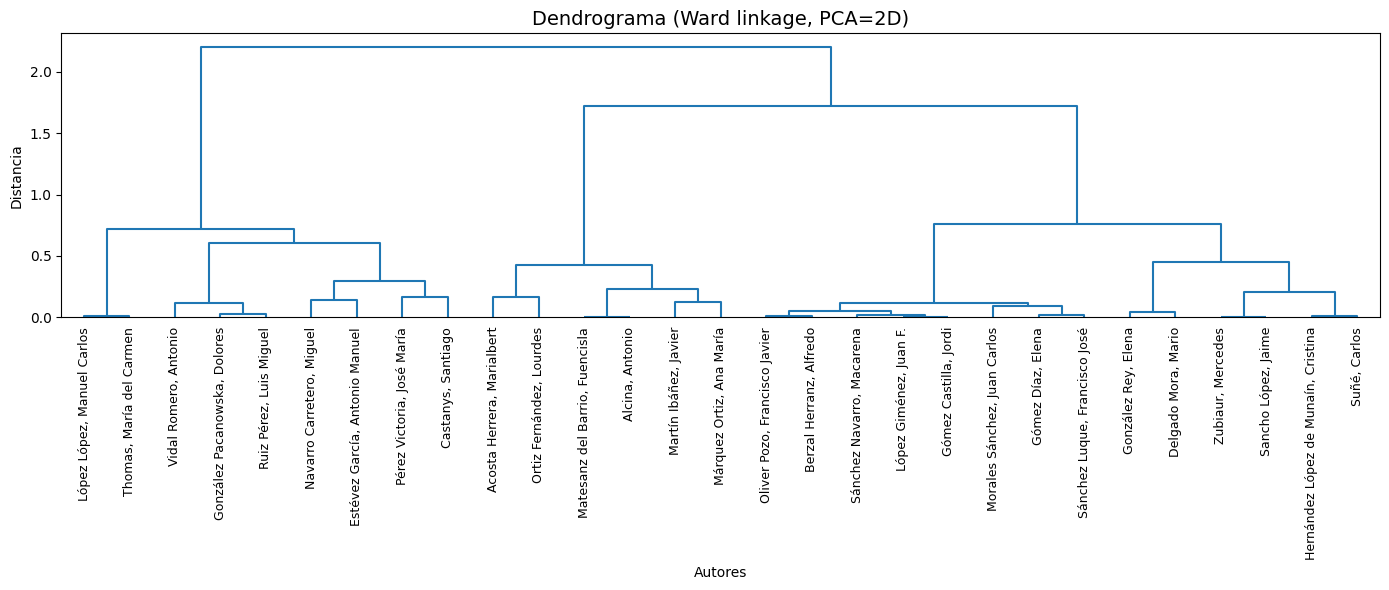

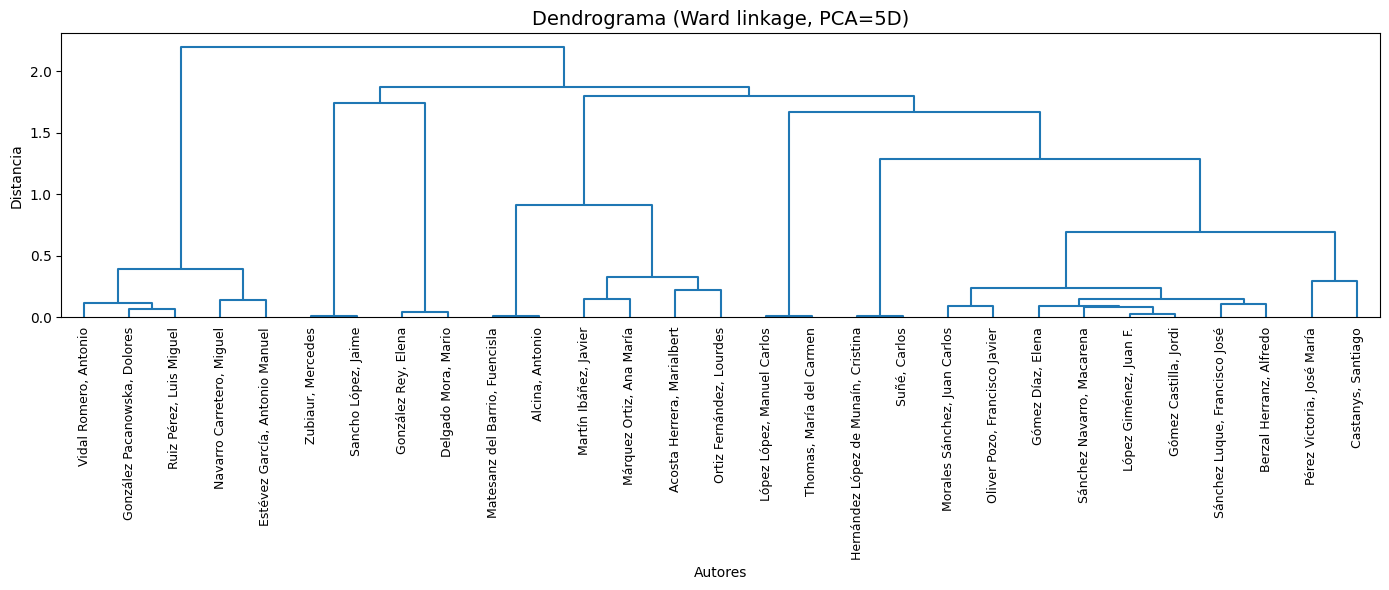

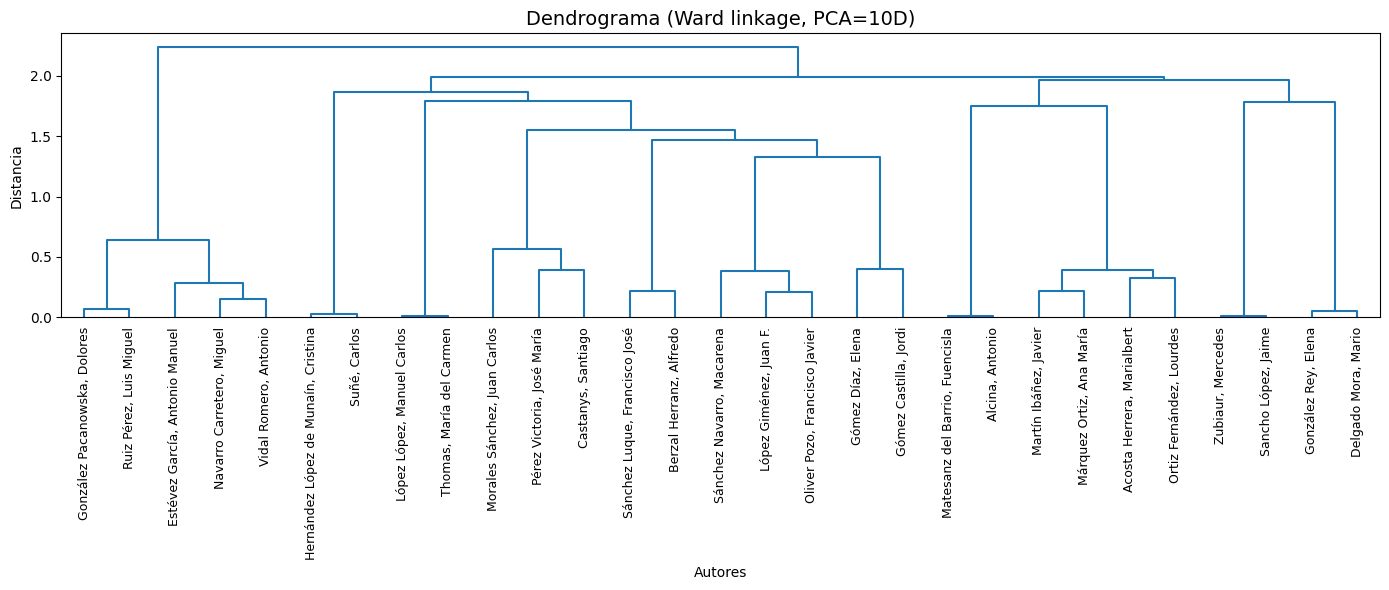

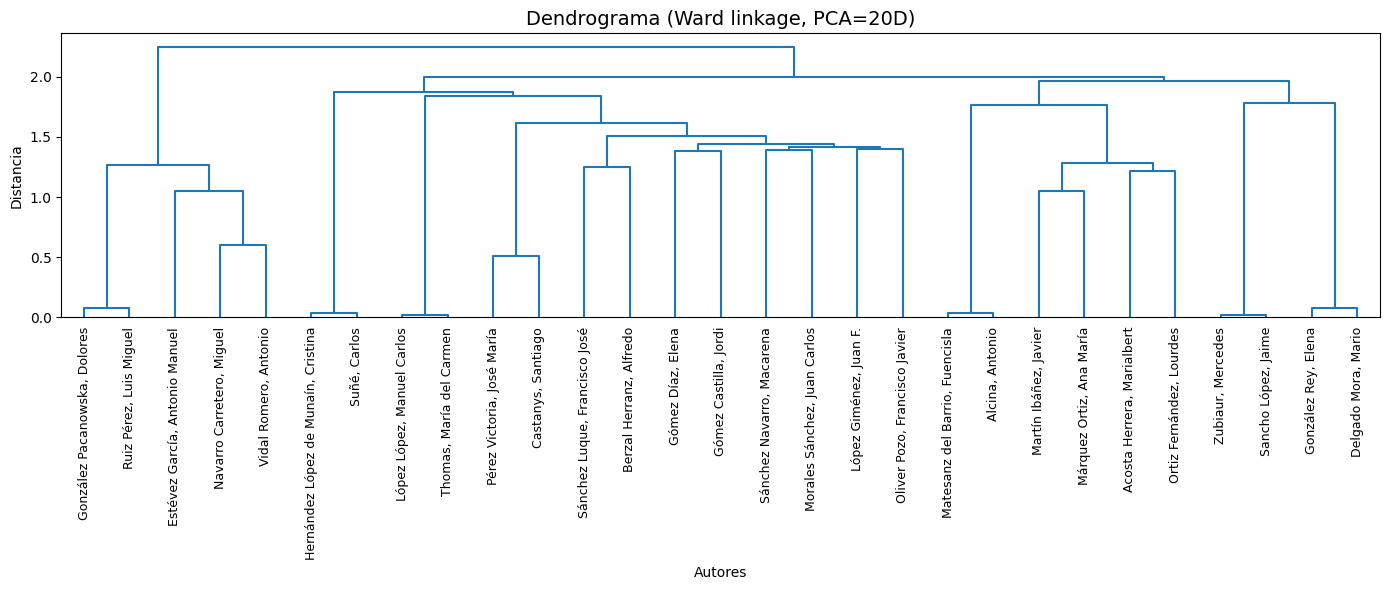

In [6]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# === Generar dendrogramas por cada configuración de PCA ===
pca_dims = [2, 5, 10, 20]
for n_dim in pca_dims:
    X_reduced = PCA(n_components=n_dim).fit_transform(X_normalized)
    
    # Linkage
    Z = linkage(X_reduced, method='ward')

    # Dendrograma
    plt.figure(figsize=(14, 6), dpi=100)
    dendrogram(
        Z,
        labels=df.index.tolist(),
        leaf_rotation=90,
        leaf_font_size=9,
        color_threshold=0  # puedes ajustar esto si quieres color automático
    )
    plt.title(f"Dendrograma (Ward linkage, PCA={n_dim}D)", fontsize=14)
    plt.xlabel("Autores")
    plt.ylabel("Distancia")
    plt.tight_layout()
    
    # Guardar cada dendrograma como imagen
    plt.savefig(f"Keywords/Hierarchical/dendrogram_pca_{n_dim}.png")
    plt.show()



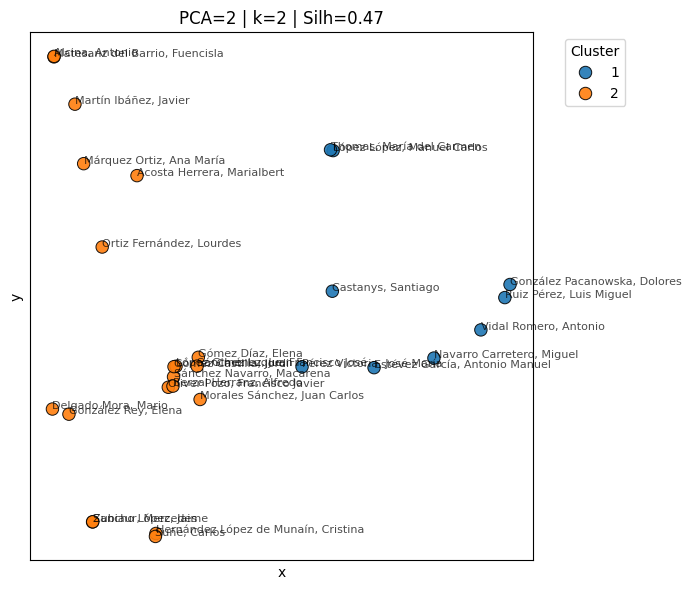

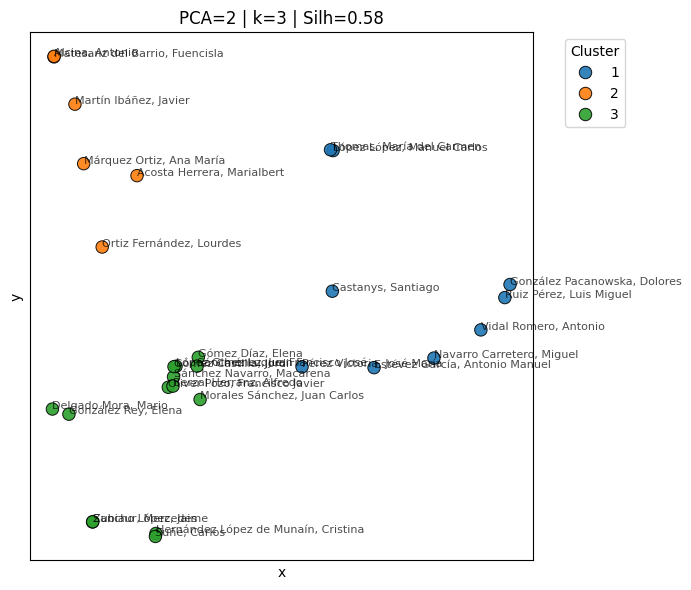

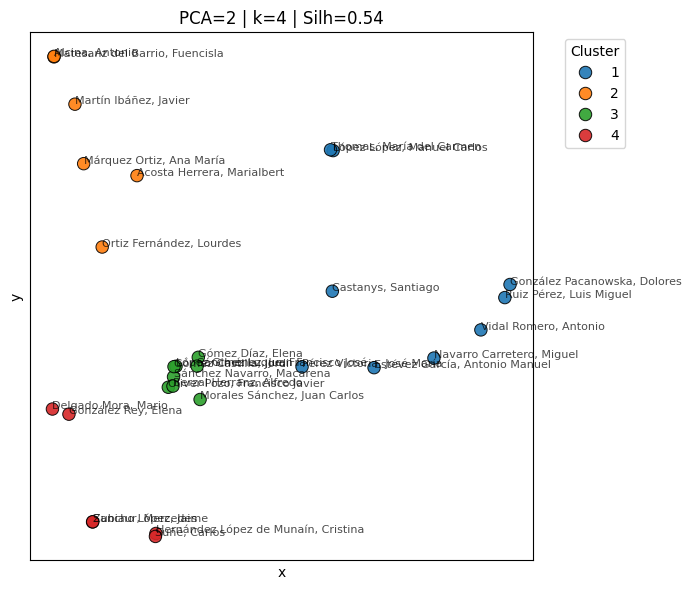

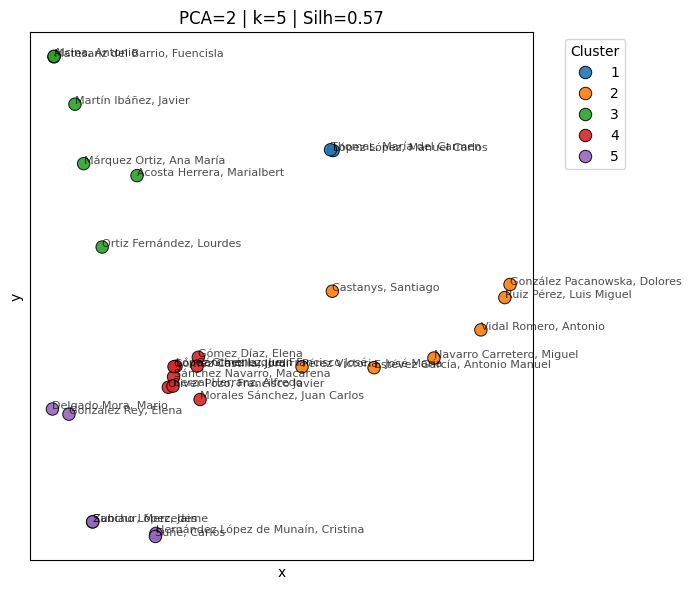

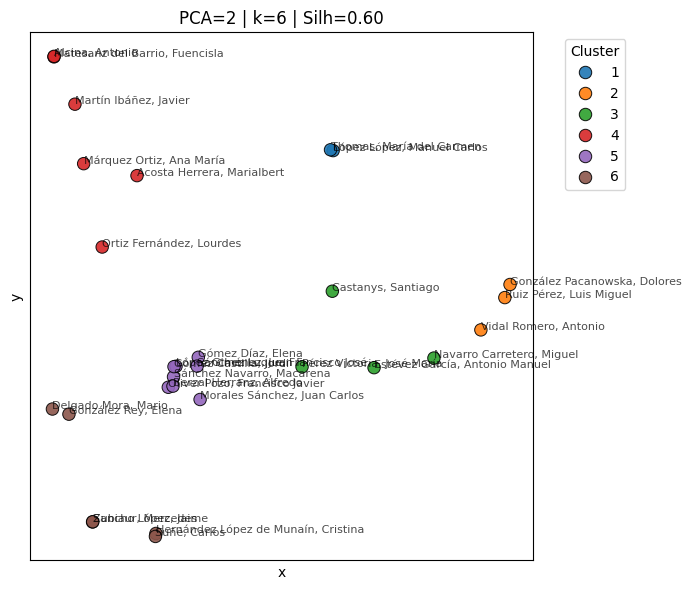

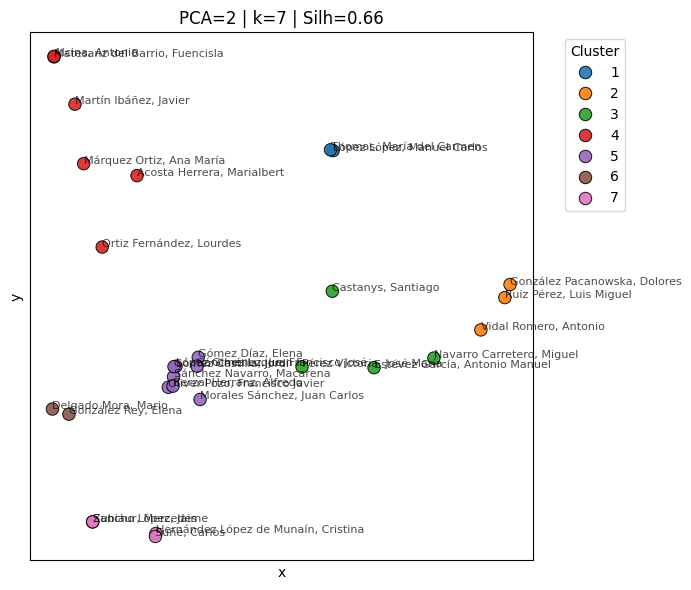

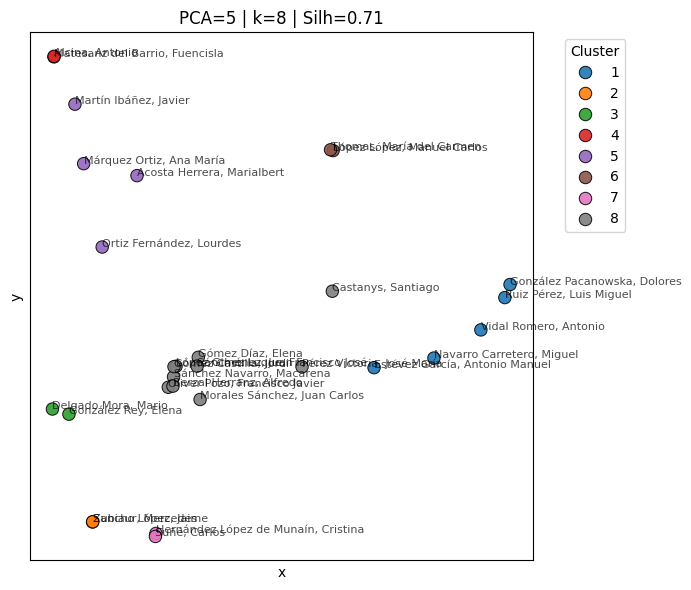

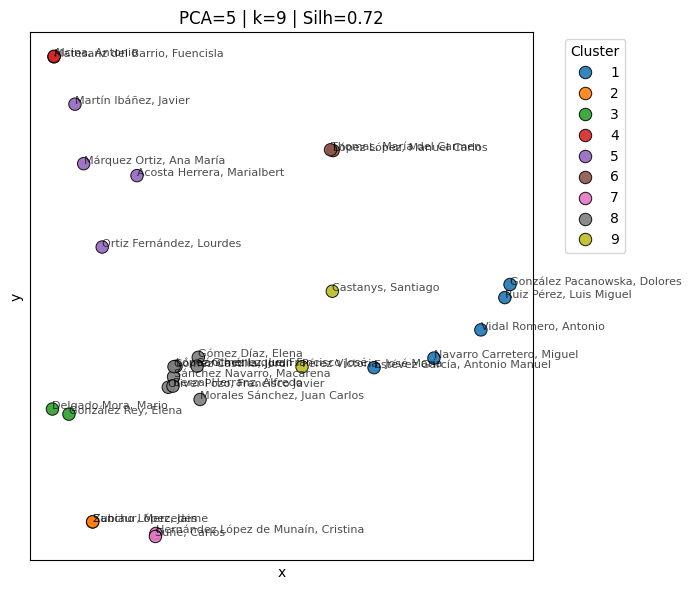

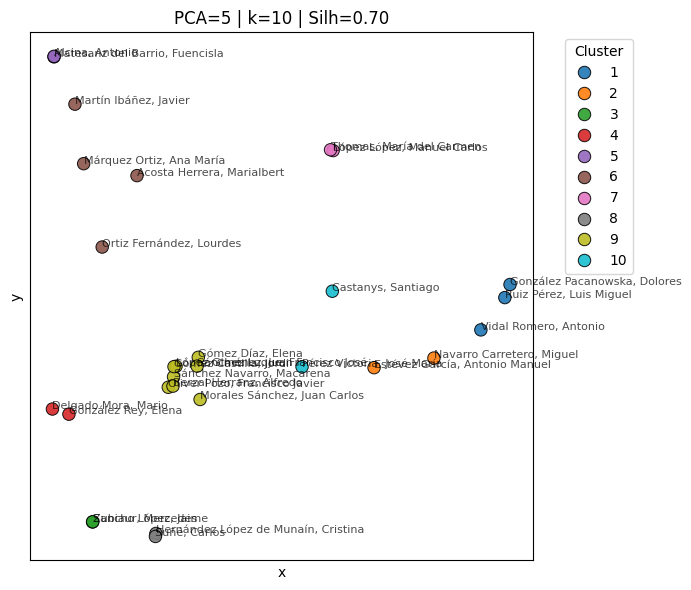

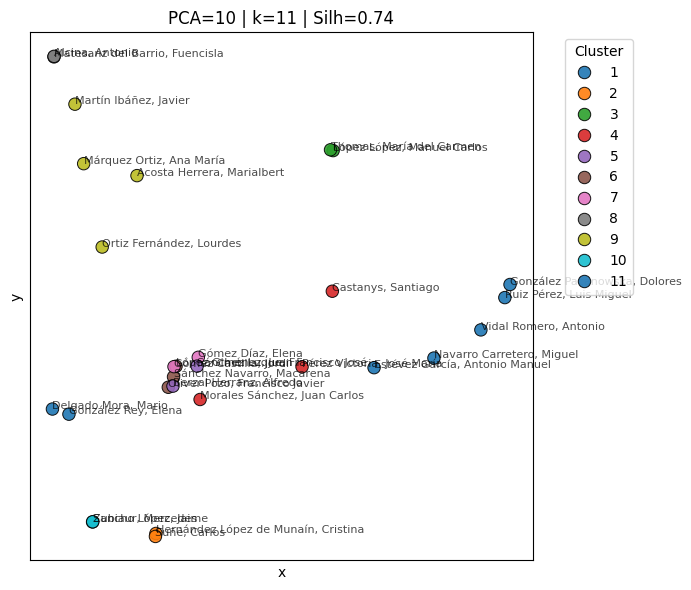

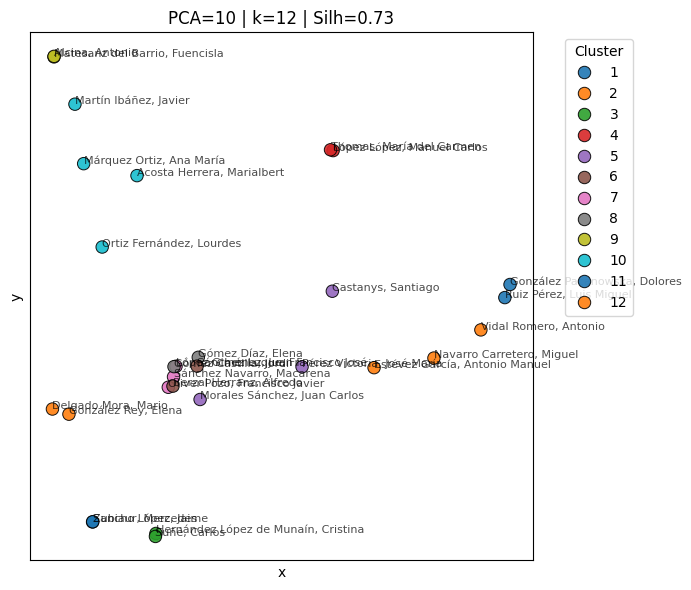

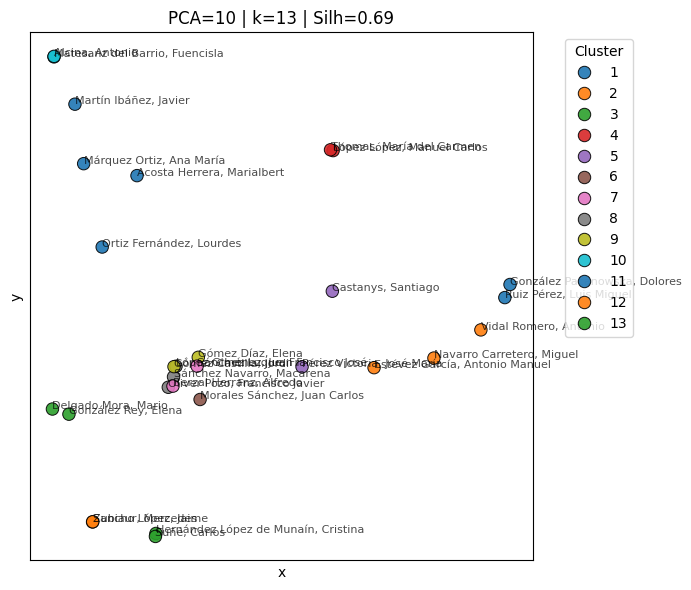

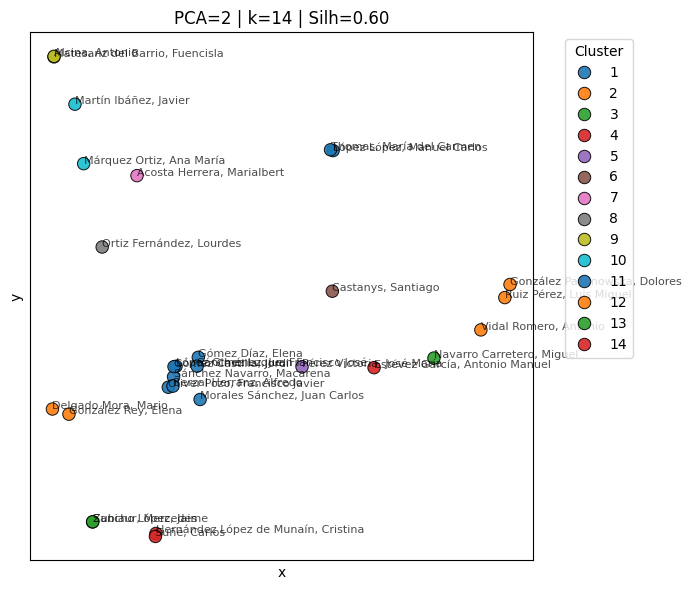

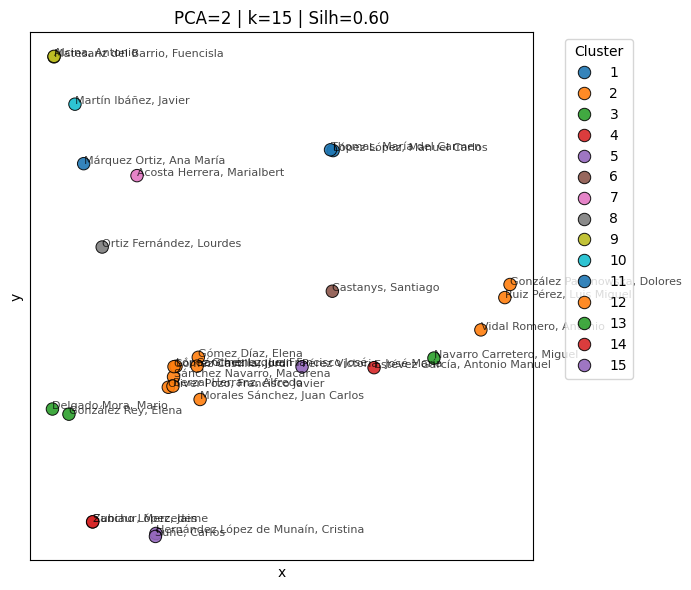

In [7]:
## Visualización
X_2d = PCA(n_components=2).fit_transform(X_normalized)

for _, row in best_per_k.iterrows():
    labels = row["Labels"]
    coords_df = pd.DataFrame(X_2d, columns=["x", "y"])
    coords_df["author"] = df.index
    coords_df["cluster"] = labels

    plt.figure(figsize=(7, 6), dpi=100)
    sns.scatterplot(
        data=coords_df,
        x="x", y="y",
        hue="cluster",
        palette="tab10",
        s=80,
        edgecolor='k',
        alpha=0.9
    )

    for _, r in coords_df.iterrows():
        plt.text(r["x"], r["y"], r["author"], fontsize=8, alpha=0.7)

    plt.title(f"PCA={row['PCA_dims']} | k={row['k']} | Silh={row['Silhouette']:.2f}")
    plt.xticks([]); plt.yticks([])
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



Guardamos los resultados

In [8]:
## Guardar resultados
cluster_records = []

for _, row in best_per_k.iterrows():
    labels = row["Labels"]
    k = row["k"]
    pca_dims = row["PCA_dims"]
    silhouette = row["Silhouette"]
    ch_score = row["Calinski-Harabasz"]
    db_score = row["Davies-Bouldin"]

    for author, cluster in zip(df.index, labels):
        cluster_records.append({
            "author": author,
            "cluster": int(cluster),
            "k": k,
            "pca_dims": pca_dims,
            "silhouette": silhouette,
            "calinski_harabasz": ch_score,
            "davies_bouldin": db_score
        })

df_clusters_export = pd.DataFrame(cluster_records)
df_clusters_export.to_csv("Keywords/Hierarchical/hierarchical_best_configs.csv", index=False)
print("✅ Resultados jerárquicos guardados en CSV.")

✅ Resultados jerárquicos guardados en CSV.
